# SageMaker endpoint

To deploy the model you previously trained, you need to create a Sagemaker Endpoint. This is a hosted prediction service that you can use to perform inference.

## Finding the model

This notebook uses a stored model if it exists. If you recently ran a training example that use the `%store%` magic, it will be restored in the next cell.

Otherwise, you can pass the URI to the model file (a .tar.gz file) in the `model_data` variable.

You can find your model files through the [SageMaker console](https://console.aws.amazon.com/sagemaker/home) by choosing **Training > Training jobs** in the left navigation pane. Find your recent training job, choose it, and then look for the `s3://` link in the **Output** pane. Uncomment the model_data line in the next cell that manually sets the model's URI.

In [1]:
# Retrieve a saved model from a previous notebook run's stored variable
%store -r model_data

# If no model was found, set it manually here.
# model_data = 's3://sagemaker-us-west-2-688520471316/pytorch-herring-mnist-2020-10-16-17-15-16-419/output/model.tar.gz'

print("Using this model: {}".format(model_data))

Using this model: s3://sagemaker-us-west-2-230755935769/resnet-aoi-2021-03-06-14-21-44-997/output/model.tar.gz


## Create a model object

You define the model object by using SageMaker SDK's `TensorFlowModel` and pass in the model from the `estimator` and the `entry_point`. The function loads the model and sets it to use a GPU, if available.

In [2]:
import sagemaker
role = sagemaker.get_execution_role()

from sagemaker.tensorflow import TensorFlowModel
model = TensorFlowModel(model_data=model_data, role=role, framework_version='2.3')

### Deploy the model on an endpoint

You create a `predictor` by using the `model.deploy` function. You can optionally change both the instance count and instance type.

In [3]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

### Test the endpoint

In [19]:
!pip install tensorflow==2.3.1

     |████████████████████████████████| 320.4 MB 32 kB/s s eta 0:00:01
     |████████████████████████████████| 20.1 MB 21.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 67.2 MB/s eta 0:00:01
     |████████████████████████████████| 136 kB 68.1 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 63.5 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 70.6 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 43.4 MB/s eta 0:00:01
     |████████████████████████████████| 459 kB 21.4 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1

In [32]:
DATA_GENERATOR_KWARGS = {"rescale": 1.0 / 255, "validation_split": 0.20}
IMAGE_SIZE = (224, 224)
batch_size = 32
INTERPOLATION = "bilinear"
dataflow_kwargs = dict(
    target_size=IMAGE_SIZE, batch_size=batch_size, interpolation=INTERPOLATION, 
)
data_dir = '/home/ec2-user/SageMaker/resnet-aoi-2/2-False'
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**DATA_GENERATOR_KWARGS)
# valid_generator = valid_datagen.flow_from_directory(data_dir, subset="validation", shuffle=False, **dataflow_kwargs)
valid_generator = valid_datagen.flow_from_directory(data_dir, subset="training", shuffle=False, **dataflow_kwargs)


(test_images, test_labels) = valid_generator.next()
test_images.shape

Found 4044 images belonging to 3 classes.


(32, 224, 224, 3)

(16, 224, 224, 3)


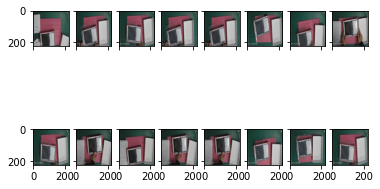

In [33]:
# Download the test set
import tensorflow as tf


import numpy as np
import random

mask = random.sample(range(0, len(test_images)), 16)
mask = np.array(mask, dtype=np.int8)
samples = test_images[mask]
print(samples.shape)
# Inspect sample images
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True)
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.imshow(samples[8*i+j].reshape(224, 224,3))

In [21]:
!pip install tensorflow==2.4.1

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [34]:
import keras
import tensorflow as tf 
export_dir = '/home/ec2-user/SageMaker/1/tf_model/1/'

model = tf.saved_model.load(export_dir)

# model = keras.models.load_model(
#     export_dir, custom_objects=None, compile=False
# )




# # Send the samples to the endpoint for inference
# # samples = np.expand_dims(samples, axis=3)
# outputs = predictor.predict(samples)['predictions']
# outputs = np.array(outputs, dtype=np.float32)


# print("Predictions: ")
# print(np.argmax(outputs, axis=1))


In [35]:
model(samples)

# output = model.predict(valid_generator, 100)

<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[ 631.87244 , -630.5785  ],
       [ 210.22893 , -212.07726 ],
       [ 373.56607 , -374.1962  ],
       [ 318.82773 , -320.4497  ],
       [ 344.64484 , -345.94772 ],
       [ 349.40363 , -348.81842 ],
       [ 117.345634, -119.40288 ],
       [ 412.60773 , -415.386   ],
       [ 289.1869  , -289.77094 ],
       [ 251.91978 , -252.5049  ],
       [ 245.94737 , -245.20387 ],
       [ 251.91978 , -252.5049  ],
       [ 251.91978 , -252.5049  ],
       [  75.74807 ,  -75.8062  ],
       [  25.459738,  -26.32948 ],
       [ 369.15405 , -369.81024 ]], dtype=float32)>

## Cleanup

If you don't intend to try out inference or to do anything else with the endpoint, you should delete the endpoint.